## Семинар: "Методы оптимизации"

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

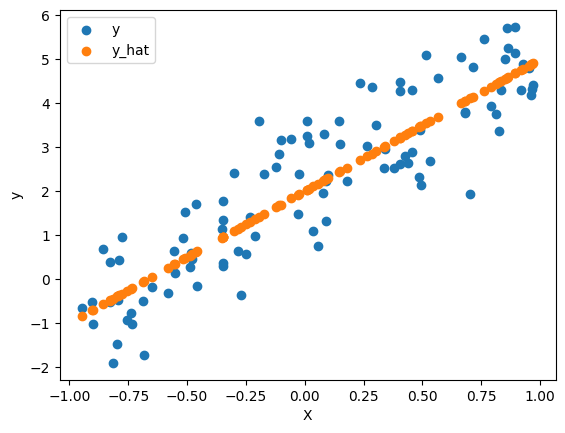

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

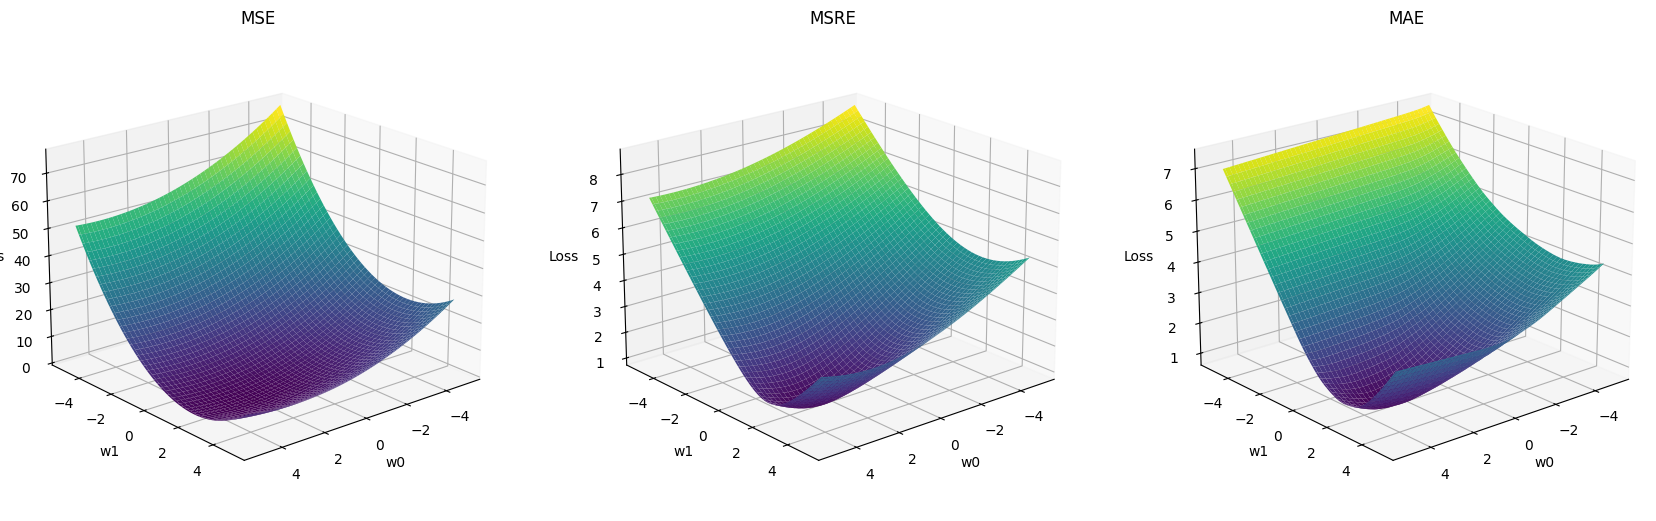

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [9]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [10]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [11]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [12]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [13]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [14]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [15]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2025-09-30 20:46:14--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2025-09-30 20:46:15--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [             <=>    ]  33.20M  10.3MB/s    in 3.2s    

2025-09-30 20:46:19 (10.3 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [16]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [17]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def step(self):
        pass

In [18]:
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 1.0,
        end_factor: float = 0.1,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters
        self.base_lr = optimizer.lr
        self.step_count = 0

    def step(self):
        self.step_count += 1
        if self.step_count <= self.total_iters:
            # Линейная интерполяция между start_factor и end_factor
            factor = self.start_factor + (self.end_factor - self.start_factor) * (self.step_count / self.total_iters)
            self.optimizer.lr = self.base_lr * factor
        else:
            # После total_iters используем end_factor
            self.optimizer.lr = self.base_lr * self.end_factor

    def get_lr(self):
        return self.optimizer.lr

class CosineAnnealingLR(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 50,
            eta_min: float = 1e-6
        ):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min
        self.eta_max = optimizer.lr
        self.step_count = 0

    def step(self):
        self.step_count += 1
        # Косинусоидальное затухание
        import math
        self.optimizer.lr = self.eta_min + (self.eta_max - self.eta_min) * \
                           (1 + math.cos(math.pi * (self.step_count % self.T_max) / self.T_max)) / 2

    def get_lr(self):
        return self.optimizer.lr

In [19]:
# Реализация Adam
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0):
        super().__init__(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay

        # Инициализация момент буферов
        self.m = [torch.zeros_like(p) for p in self.params]  # Первый момент
        self.v = [torch.zeros_like(p) for p in self.params]  # Второй момент
        self.step_count = 0

    def step(self):
        self.step_count += 1

        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue

                grad = param.grad

                # Добавление weight decay к градиенту (L2 регуляризация)
                if self.weight_decay != 0:
                    grad = grad + self.weight_decay * param

                # Обновление экспоненциальных скользящих средних
                self.m[i].mul_(self.beta1).add_(grad, alpha=1 - self.beta1)
                self.v[i].mul_(self.beta2).addcmul_(grad, grad, value=1 - self.beta2)

                # Bias correction
                bias_correction1 = 1 - self.beta1 ** self.step_count
                bias_correction2 = 1 - self.beta2 ** self.step_count

                # Корректированные моменты
                m_hat = self.m[i] / bias_correction1
                v_hat = self.v[i] / bias_correction2

                # Обновление параметров
                param.addcdiv_(m_hat, torch.sqrt(v_hat) + self.eps, value=-self.lr)

# Реализация AdamW
class AdamW(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        super().__init__(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay

        # Инициализация момент буферов
        self.m = [torch.zeros_like(p) for p in self.params]  # Первый момент
        self.v = [torch.zeros_like(p) for p in self.params]  # Второй момент
        self.step_count = 0

    def step(self):
        self.step_count += 1

        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue

                grad = param.grad

                # Обновление экспоненциальных скользящих средних (БЕЗ weight decay в градиенте)
                self.m[i].mul_(self.beta1).add_(grad, alpha=1 - self.beta1)
                self.v[i].mul_(self.beta2).addcmul_(grad, grad, value=1 - self.beta2)

                # Bias correction
                bias_correction1 = 1 - self.beta1 ** self.step_count
                bias_correction2 = 1 - self.beta2 ** self.step_count

                # Корректированные моменты
                m_hat = self.m[i] / bias_correction1
                v_hat = self.v[i] / bias_correction2

                # Обновление параметров с адаптивным градиентом
                param.addcdiv_(m_hat, torch.sqrt(v_hat) + self.eps, value=-self.lr)

                # Отдельное применение weight decay
                if self.weight_decay != 0:
                    param.mul_(1 - self.lr * self.weight_decay)

In [20]:
# Создание CNN архитектуры для MNIST
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Pooling слои
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # 28x28 -> 14x14 -> 7x7 -> 3x3 после pooling
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Первый блок: conv + relu + pool
        x = self.pool(nn.functional.relu(self.conv1(x)))

        # Второй блок: conv + relu + pool
        x = self.pool(nn.functional.relu(self.conv2(x)))

        # Третий блок: conv + relu + pool
        x = self.pool(nn.functional.relu(self.conv3(x)))

        # Преобразование в вектор
        x = x.view(x.size(0), -1)

        # Полносвязные слои
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# Тестирование архитектуры
model = SimpleCNN().to(device)
print(f"Количество параметров: {sum(p.numel() for p in model.parameters()):,}")

# Тест с примером входа
test_input = torch.randn(1, 1, 28, 28).to(device)
test_output = model(test_input)
print(f"Размер выхода: {test_output.shape}")

Используемое устройство: cuda
Количество параметров: 390,410
Размер выхода: torch.Size([1, 10])


In [21]:
# Функции для обучения и оценки
def train_epoch(model, train_loader, optimizer, criterion, scheduler=None):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc='Обучение')

    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        output = model(data)
        loss = criterion(output, target)

        # Обратный проход
        loss.backward()
        optimizer.step()

        # Обновление планировщика (если есть)
        if scheduler is not None:
            scheduler.step()

        # Статистика
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        # Обновление прогресс-бара
        if hasattr(optimizer, 'lr'):
            lr_str = f'{optimizer.lr:.6f}'
        else:
            lr_str = 'N/A'

        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100. * correct / total:.2f}%',
            'LR': lr_str
        })

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Оценка'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

In [22]:
# Функция для полного обучения модели
def train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs, experiment_name):
    criterion = nn.CrossEntropyLoss()

    # История обучения
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'lr': []
    }

    print(f"\nНачало эксперимента: {experiment_name}")

    for epoch in range(num_epochs):
        print(f"\nЭпоха {epoch + 1}/{num_epochs}")

        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, scheduler)

        # Оценка
        test_loss, test_acc = evaluate(model, test_loader, criterion)

        # Сохранение метрик
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['lr'].append(optimizer.lr if hasattr(optimizer, 'lr') else 0.001)

        print(f"Обучение: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"Тест: Loss={test_loss:.4f}, Acc={test_acc:.2f}%")
        print(f"Learning Rate: {history['lr'][-1]:.6f}")

    print(f"\nКонец эксперимента: {experiment_name}")
    return history

In [23]:
# Запуск экспериментов
num_epochs = 5
learning_rate = 0.001
weight_decay = 1e-4

# Конфигурации экспериментов
experiments = [
    # Без планировщиков
    {'optimizer': 'SGD', 'scheduler': None, 'name': 'SGD'},
    {'optimizer': 'Adam', 'scheduler': None, 'name': 'Adam'},
    {'optimizer': 'AdamW', 'scheduler': None, 'name': 'AdamW'},

    # С LinearLR
    {'optimizer': 'SGD', 'scheduler': 'LinearLR', 'name': 'SGD + LinearLR'},
    {'optimizer': 'Adam', 'scheduler': 'LinearLR', 'name': 'Adam + LinearLR'},
    {'optimizer': 'AdamW', 'scheduler': 'LinearLR', 'name': 'AdamW + LinearLR'},

    # С CosineAnnealingLR
    {'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'name': 'SGD + CosineAnnealingLR'},
    {'optimizer': 'Adam', 'scheduler': 'CosineAnnealingLR', 'name': 'Adam + CosineAnnealingLR'},
    {'optimizer': 'AdamW', 'scheduler': 'CosineAnnealingLR', 'name': 'AdamW + CosineAnnealingLR'},
]

# Словарь для хранения результатов всех экспериментов
all_results = {}

print(f"Запуск {len(experiments)} экспериментов...")

Запуск 9 экспериментов...


In [24]:
# Запуск всех экспериментов
for i, config in enumerate(experiments):
    print(f"\n{'='*60}")
    print(f"ЭКСПЕРИМЕНТ {i+1}/{len(experiments)}: {config['name']}")
    print(f"{'='*60}")

    # Создание новой модели для каждого эксперимента
    model = SimpleCNN().to(device)

    # Создание оптимизатора
    if config['optimizer'] == 'SGD':
        optimizer = SGD(model.parameters(), lr=learning_rate)
    elif config['optimizer'] == 'Adam':
        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif config['optimizer'] == 'AdamW':
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Создание планировщика
    scheduler = None
    if config['scheduler'] == 'LinearLR':
        scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.1,
                           total_iters=len(train_loader) * num_epochs)
    elif config['scheduler'] == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * num_epochs // 2,
                                    eta_min=learning_rate * 0.01)

    # Обучение модели
    history = train_model(model, train_loader, test_loader, optimizer, scheduler,
                         num_epochs, config['name'])

    # Сохранение результатов
    all_results[config['name']] = history

    print(f"Финальная точность на тесте: {history['test_acc'][-1]:.2f}%")

print("\n" + "="*60)
print("ВСЕ ЭКСПЕРИМЕНТЫ ЗАВЕРШЕНЫ!")
print("="*60)


ЭКСПЕРИМЕНТ 1/9: SGD

Начало эксперимента: SGD

Эпоха 1/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=2.1542, Acc=45.73%
Тест: Loss=1.6105, Acc=67.90%
Learning Rate: 0.001000

Эпоха 2/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.7335, Acc=81.78%
Тест: Loss=0.3861, Acc=89.06%
Learning Rate: 0.001000

Эпоха 3/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.3300, Acc=90.13%
Тест: Loss=0.2727, Acc=91.53%
Learning Rate: 0.001000

Эпоха 4/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.2359, Acc=92.93%
Тест: Loss=0.1963, Acc=93.91%
Learning Rate: 0.001000

Эпоха 5/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.1878, Acc=94.27%
Тест: Loss=0.1634, Acc=95.12%
Learning Rate: 0.001000

Конец эксперимента: SGD
Финальная точность на тесте: 95.12%

ЭКСПЕРИМЕНТ 2/9: Adam

Начало эксперимента: Adam

Эпоха 1/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.1153, Acc=96.36%
Тест: Loss=0.0402, Acc=98.60%
Learning Rate: 0.001000

Эпоха 2/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0413, Acc=98.72%
Тест: Loss=0.0451, Acc=98.62%
Learning Rate: 0.001000

Эпоха 3/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0308, Acc=99.02%
Тест: Loss=0.0431, Acc=98.57%
Learning Rate: 0.001000

Эпоха 4/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0262, Acc=99.18%
Тест: Loss=0.0375, Acc=98.91%
Learning Rate: 0.001000

Эпоха 5/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0220, Acc=99.29%
Тест: Loss=0.0292, Acc=99.14%
Learning Rate: 0.001000

Конец эксперимента: Adam
Финальная точность на тесте: 99.14%

ЭКСПЕРИМЕНТ 3/9: AdamW

Начало эксперимента: AdamW

Эпоха 1/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.1186, Acc=96.22%
Тест: Loss=0.0356, Acc=98.89%
Learning Rate: 0.001000

Эпоха 2/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0410, Acc=98.75%
Тест: Loss=0.0336, Acc=98.91%
Learning Rate: 0.001000

Эпоха 3/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0310, Acc=98.99%
Тест: Loss=0.0349, Acc=98.85%
Learning Rate: 0.001000

Эпоха 4/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0223, Acc=99.31%
Тест: Loss=0.0267, Acc=99.07%
Learning Rate: 0.001000

Эпоха 5/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0172, Acc=99.45%
Тест: Loss=0.0296, Acc=99.13%
Learning Rate: 0.001000

Конец эксперимента: AdamW
Финальная точность на тесте: 99.13%

ЭКСПЕРИМЕНТ 4/9: SGD + LinearLR

Начало эксперимента: SGD + LinearLR

Эпоха 1/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=2.2284, Acc=35.51%
Тест: Loss=2.0591, Acc=65.15%
Learning Rate: 0.000820

Эпоха 2/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=1.2604, Acc=73.66%
Тест: Loss=0.6120, Acc=84.34%
Learning Rate: 0.000640

Эпоха 3/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.4924, Acc=86.27%
Тест: Loss=0.3879, Acc=89.18%
Learning Rate: 0.000460

Эпоха 4/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.3660, Acc=89.39%
Тест: Loss=0.3276, Acc=90.50%
Learning Rate: 0.000280

Эпоха 5/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.3190, Acc=90.67%
Тест: Loss=0.2921, Acc=91.41%
Learning Rate: 0.000100

Конец эксперимента: SGD + LinearLR
Финальная точность на тесте: 91.41%

ЭКСПЕРИМЕНТ 5/9: Adam + LinearLR

Начало эксперимента: Adam + LinearLR

Эпоха 1/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.1169, Acc=96.26%
Тест: Loss=0.0415, Acc=98.67%
Learning Rate: 0.000820

Эпоха 2/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0367, Acc=98.86%
Тест: Loss=0.0346, Acc=98.94%
Learning Rate: 0.000640

Эпоха 3/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0236, Acc=99.25%
Тест: Loss=0.0253, Acc=99.21%
Learning Rate: 0.000460

Эпоха 4/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0125, Acc=99.63%
Тест: Loss=0.0231, Acc=99.23%
Learning Rate: 0.000280

Эпоха 5/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0059, Acc=99.84%
Тест: Loss=0.0188, Acc=99.44%
Learning Rate: 0.000100

Конец эксперимента: Adam + LinearLR
Финальная точность на тесте: 99.44%

ЭКСПЕРИМЕНТ 6/9: AdamW + LinearLR

Начало эксперимента: AdamW + LinearLR

Эпоха 1/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.1114, Acc=96.56%
Тест: Loss=0.0308, Acc=98.90%
Learning Rate: 0.000820

Эпоха 2/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0344, Acc=98.96%
Тест: Loss=0.0356, Acc=98.81%
Learning Rate: 0.000640

Эпоха 3/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0209, Acc=99.32%
Тест: Loss=0.0270, Acc=99.17%
Learning Rate: 0.000460

Эпоха 4/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0102, Acc=99.68%
Тест: Loss=0.0231, Acc=99.36%
Learning Rate: 0.000280

Эпоха 5/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0038, Acc=99.89%
Тест: Loss=0.0205, Acc=99.48%
Learning Rate: 0.000100

Конец эксперимента: AdamW + LinearLR
Финальная точность на тесте: 99.48%

ЭКСПЕРИМЕНТ 7/9: SGD + CosineAnnealingLR

Начало эксперимента: SGD + CosineAnnealingLR

Эпоха 1/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=2.2476, Acc=35.30%
Тест: Loss=2.1475, Acc=61.34%
Learning Rate: 0.000658

Эпоха 2/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=1.8937, Acc=66.58%
Тест: Loss=1.6267, Acc=70.84%
Learning Rate: 0.000104

Эпоха 3/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=1.2870, Acc=73.38%
Тест: Loss=0.6236, Acc=84.05%
Learning Rate: 0.000905

Эпоха 4/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.4791, Acc=86.25%
Тест: Loss=0.3786, Acc=89.20%
Learning Rate: 0.000352

Эпоха 5/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.3709, Acc=89.29%
Тест: Loss=0.3539, Acc=89.95%
Learning Rate: 0.001000

Конец эксперимента: SGD + CosineAnnealingLR
Финальная точность на тесте: 89.95%

ЭКСПЕРИМЕНТ 8/9: Adam + CosineAnnealingLR

Начало эксперимента: Adam + CosineAnnealingLR

Эпоха 1/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.1162, Acc=96.36%
Тест: Loss=0.0307, Acc=98.96%
Learning Rate: 0.000658

Эпоха 2/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0269, Acc=99.14%
Тест: Loss=0.0228, Acc=99.29%
Learning Rate: 0.000104

Эпоха 3/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0304, Acc=99.06%
Тест: Loss=0.0330, Acc=98.95%
Learning Rate: 0.000905

Эпоха 4/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0255, Acc=99.21%
Тест: Loss=0.0260, Acc=99.17%
Learning Rate: 0.000352

Эпоха 5/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0073, Acc=99.79%
Тест: Loss=0.0174, Acc=99.42%
Learning Rate: 0.001000

Конец эксперимента: Adam + CosineAnnealingLR
Финальная точность на тесте: 99.42%

ЭКСПЕРИМЕНТ 9/9: AdamW + CosineAnnealingLR

Начало эксперимента: AdamW + CosineAnnealingLR

Эпоха 1/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.1135, Acc=96.43%
Тест: Loss=0.0297, Acc=99.11%
Learning Rate: 0.000658

Эпоха 2/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0249, Acc=99.24%
Тест: Loss=0.0196, Acc=99.39%
Learning Rate: 0.000104

Эпоха 3/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0287, Acc=99.16%
Тест: Loss=0.0272, Acc=99.02%
Learning Rate: 0.000905

Эпоха 4/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0235, Acc=99.27%
Тест: Loss=0.0212, Acc=99.32%
Learning Rate: 0.000352

Эпоха 5/5


Обучение:   0%|          | 0/1875 [00:00<?, ?it/s]

Оценка:   0%|          | 0/313 [00:00<?, ?it/s]

Обучение: Loss=0.0055, Acc=99.84%
Тест: Loss=0.0166, Acc=99.43%
Learning Rate: 0.001000

Конец эксперимента: AdamW + CosineAnnealingLR
Финальная точность на тесте: 99.43%

ВСЕ ЭКСПЕРИМЕНТЫ ЗАВЕРШЕНЫ!


In [25]:
# Функция для построения графиков
def plot_training_results(all_results, metric='loss', split='train'):
    plt.figure(figsize=(15, 10))

    # Группировка экспериментов по планировщикам
    groups = {
        'Без планировщика': ['SGD', 'Adam', 'AdamW'],
        'LinearLR': ['SGD + LinearLR', 'Adam + LinearLR', 'AdamW + LinearLR'],
        'CosineAnnealingLR': ['SGD + CosineAnnealingLR', 'Adam + CosineAnnealingLR', 'AdamW + CosineAnnealingLR']
    }

    colors = {'SGD': 'red', 'Adam': 'blue', 'AdamW': 'green'}
    line_styles = {0: '-', 1: '--', 2: ':'}

    for group_idx, (group_name, experiments) in enumerate(groups.items()):
        plt.subplot(2, 2, group_idx + 1)

        for exp_name in experiments:
            if exp_name in all_results:
                optimizer_type = exp_name.split(' +')[0].split()[0]
                data = all_results[exp_name][f'{split}_{metric}']

                plt.plot(data,
                        color=colors.get(optimizer_type, 'black'),
                        linestyle=line_styles.get(group_idx, '-'),
                        linewidth=2,
                        label=exp_name,
                        marker='o' if len(data) <= 20 else None,
                        markersize=4)

        plt.title(f'{group_name}\n{split.capitalize()} {metric.capitalize()}')
        plt.xlabel('Эпоха')
        plt.ylabel(f'{metric.capitalize()}')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Общий график всех экспериментов
    plt.subplot(2, 2, 4)
    for exp_name, results in all_results.items():
        optimizer_type = exp_name.split(' +')[0].split()[0]
        data = results[f'{split}_{metric}']

        # Определение стиля линии на основе планировщика
        if 'LinearLR' in exp_name:
            linestyle = '--'
        elif 'CosineAnnealingLR' in exp_name:
            linestyle = ':'
        else:
            linestyle = '-'

        plt.plot(data,
                color=colors.get(optimizer_type, 'black'),
                linestyle=linestyle,
                linewidth=1.5,
                label=exp_name,
                alpha=0.8)

    plt.title(f'Все эксперименты\n{split.capitalize()} {metric.capitalize()}')
    plt.xlabel('Эпоха')
    plt.ylabel(f'{metric.capitalize()}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

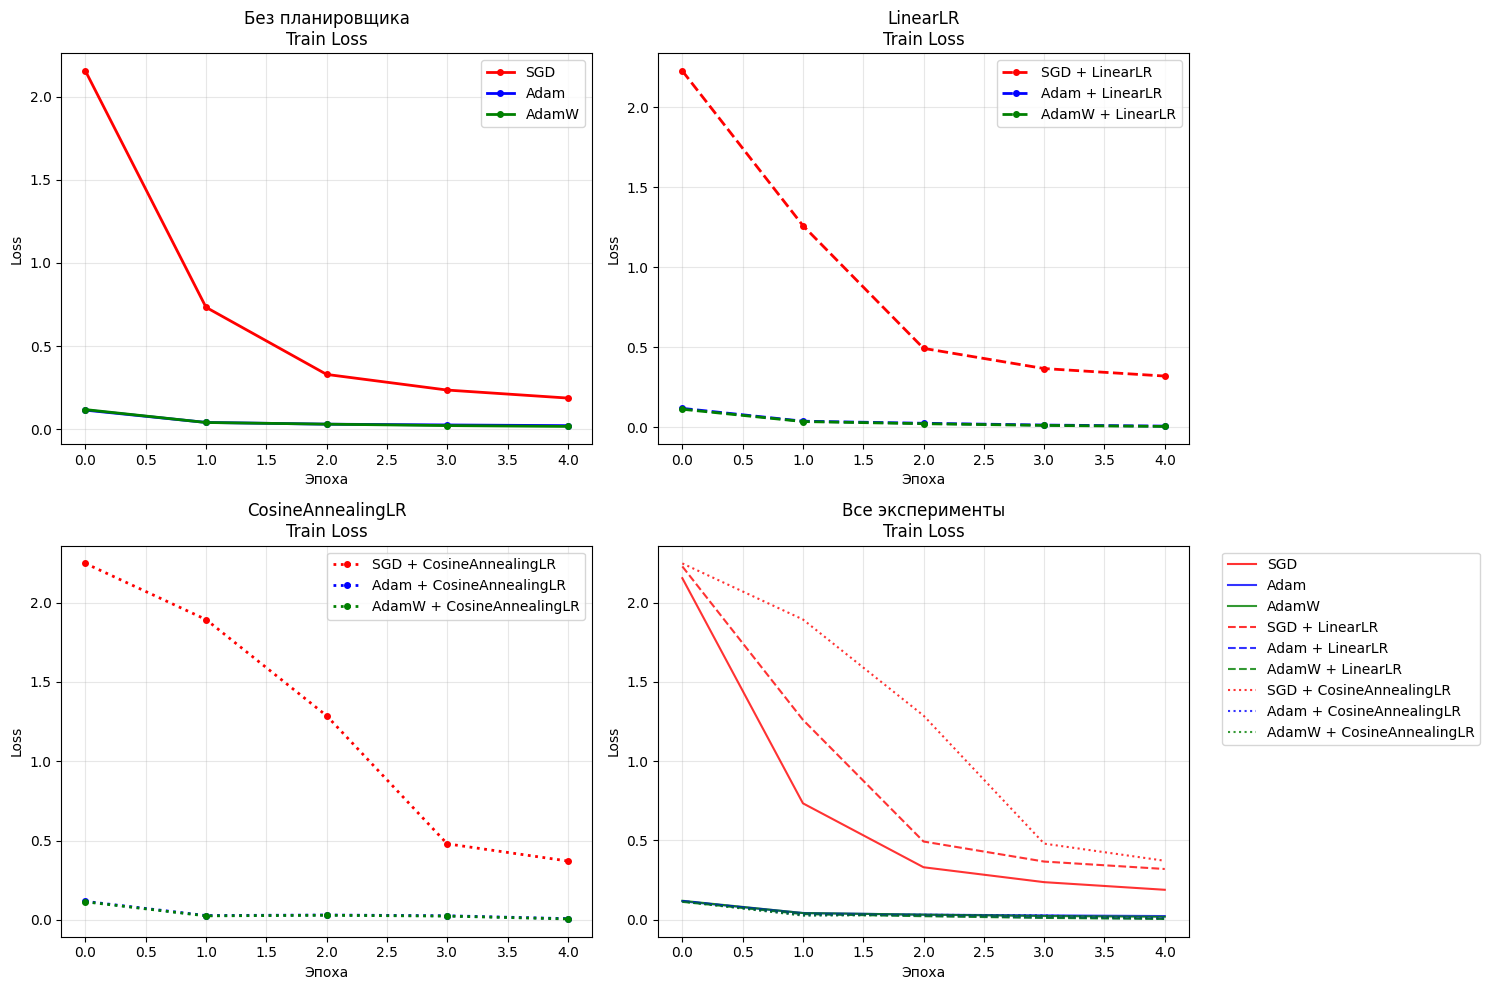

In [26]:
# Построение графиков потерь на обучающем наборе
plot_training_results(all_results, metric='loss', split='train')

я так и думал)

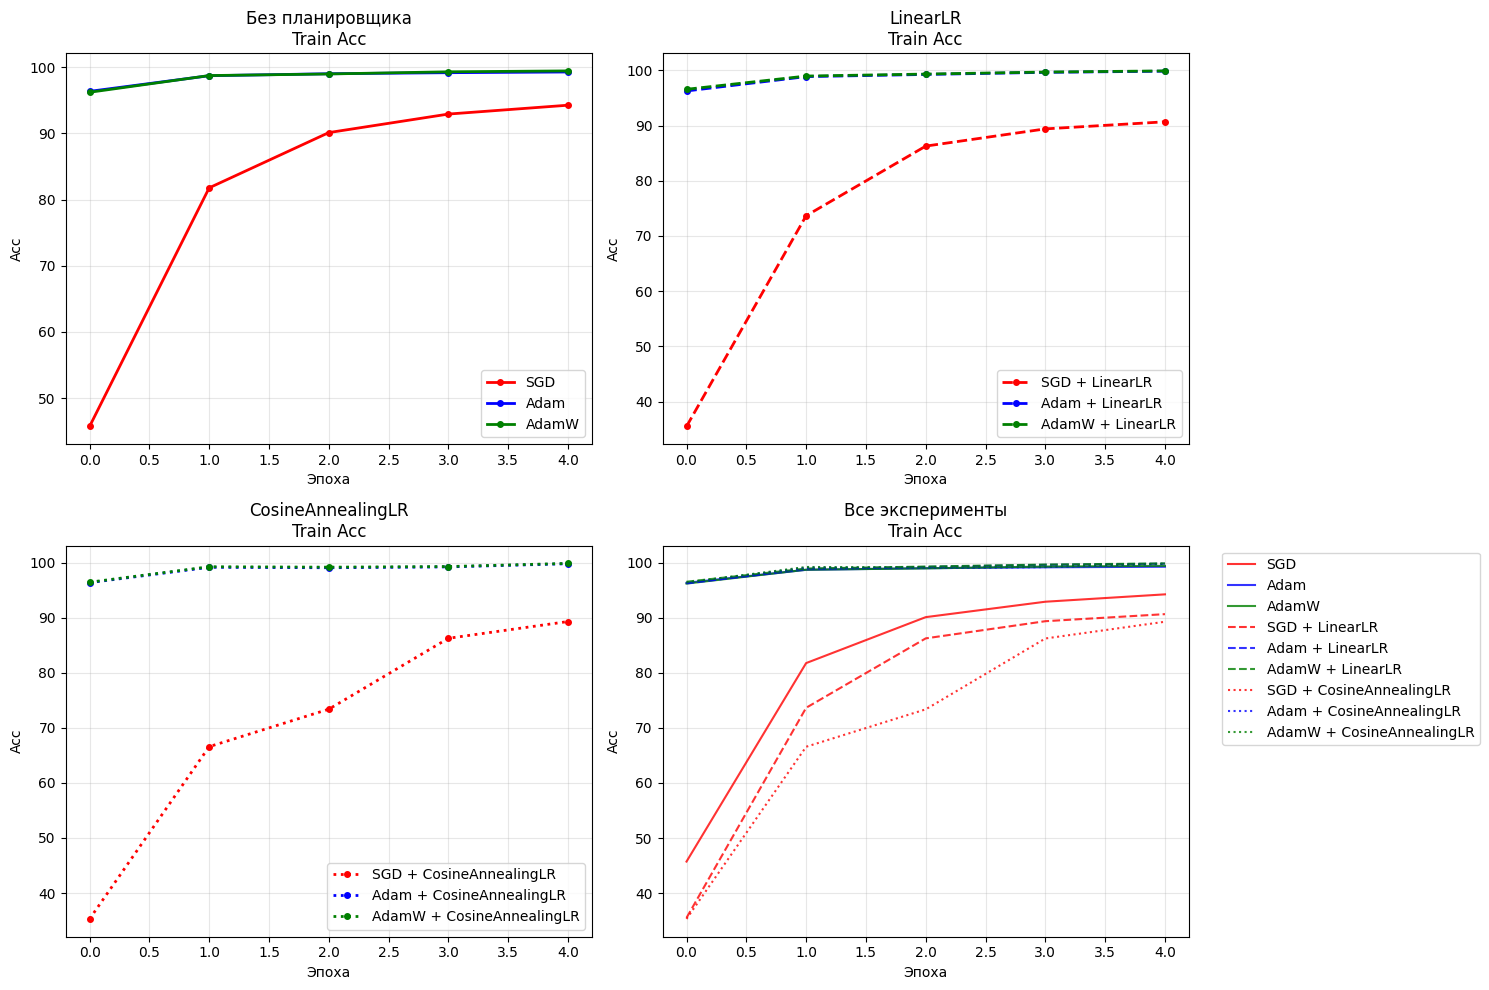

In [27]:
# Построение графиков точности на обучающем наборе
plot_training_results(all_results, metric='acc', split='train')

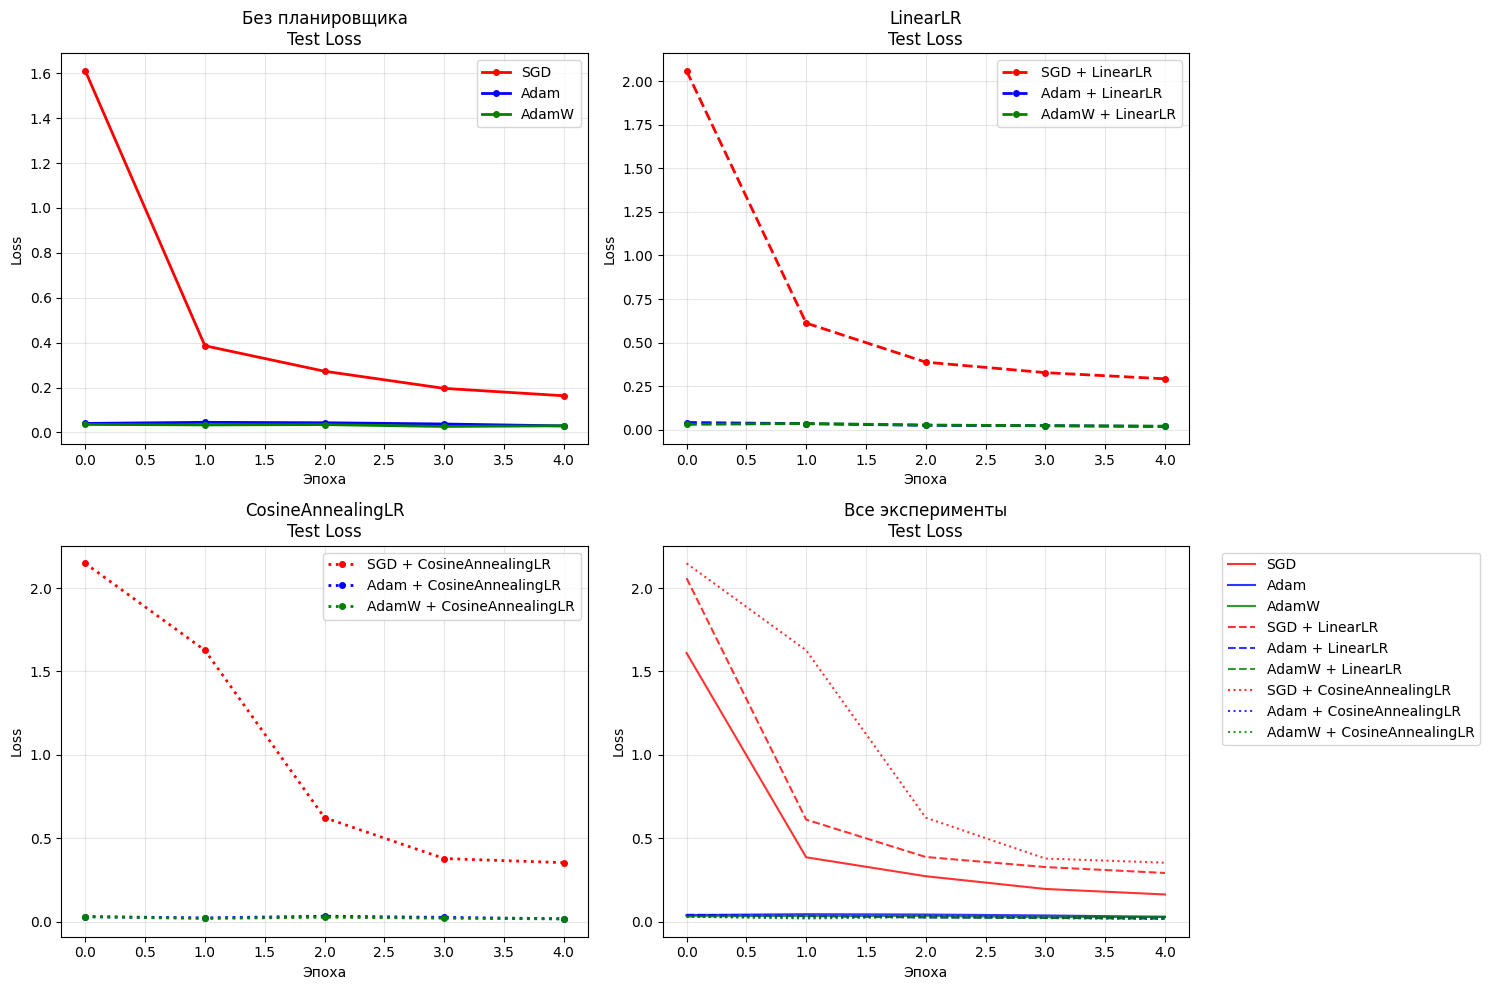

In [28]:
# Построение графиков потерь на тестовом наборе
plot_training_results(all_results, metric='loss', split='test')

до сих пор удивлён CosineAnnealingLR

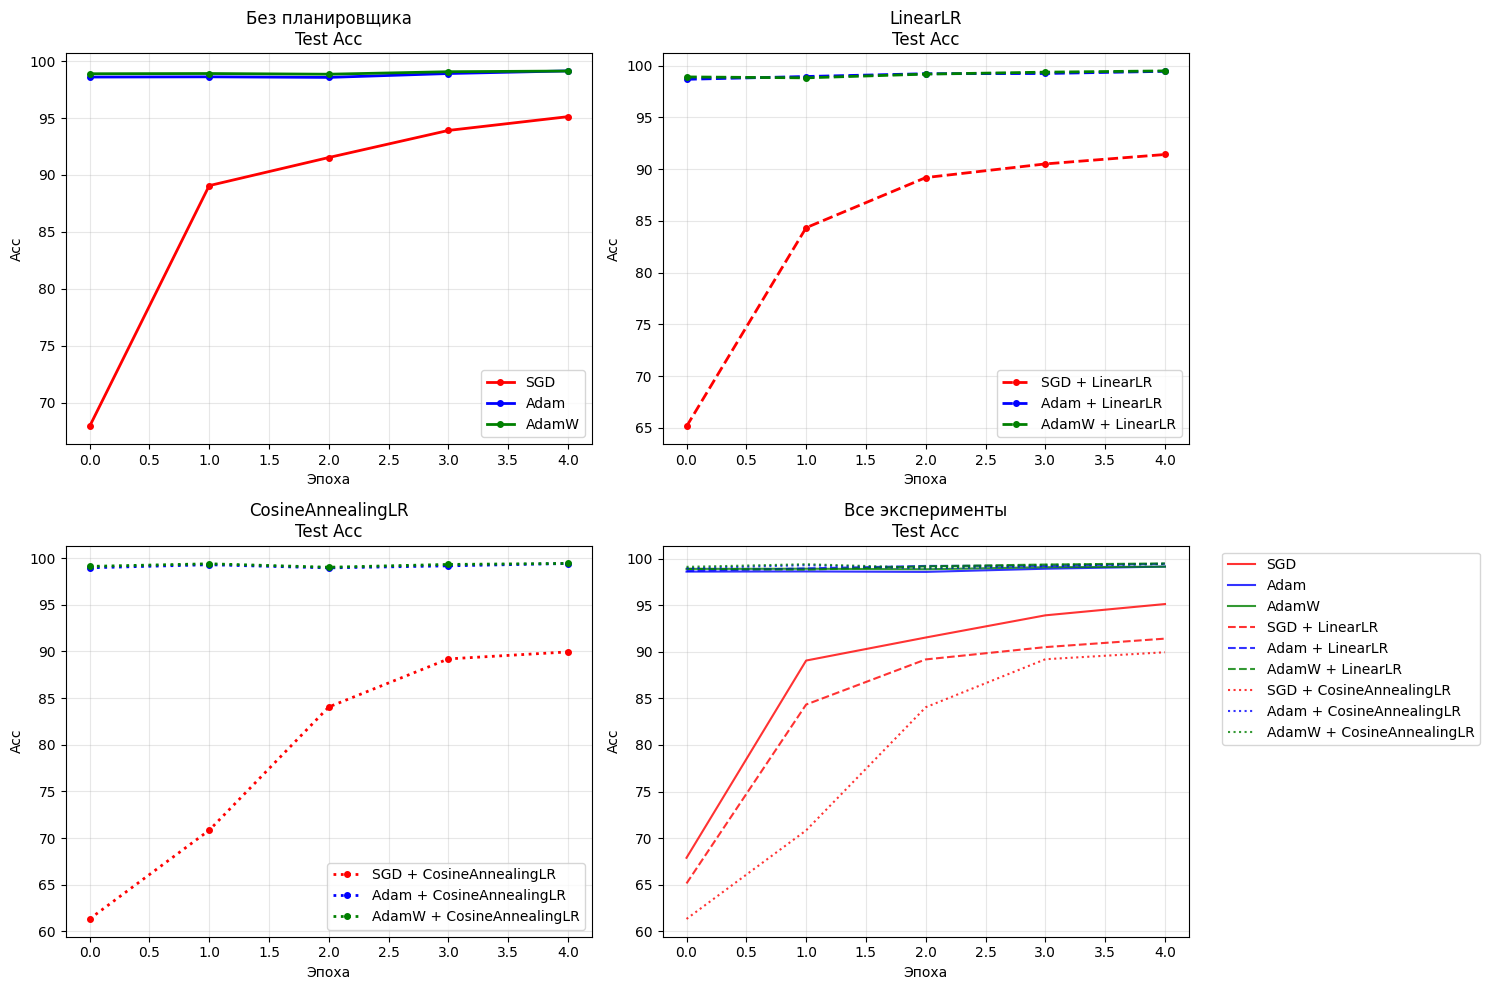

In [29]:
# Построение графиков точности на тестовом наборе
plot_training_results(all_results, metric='acc', split='test')

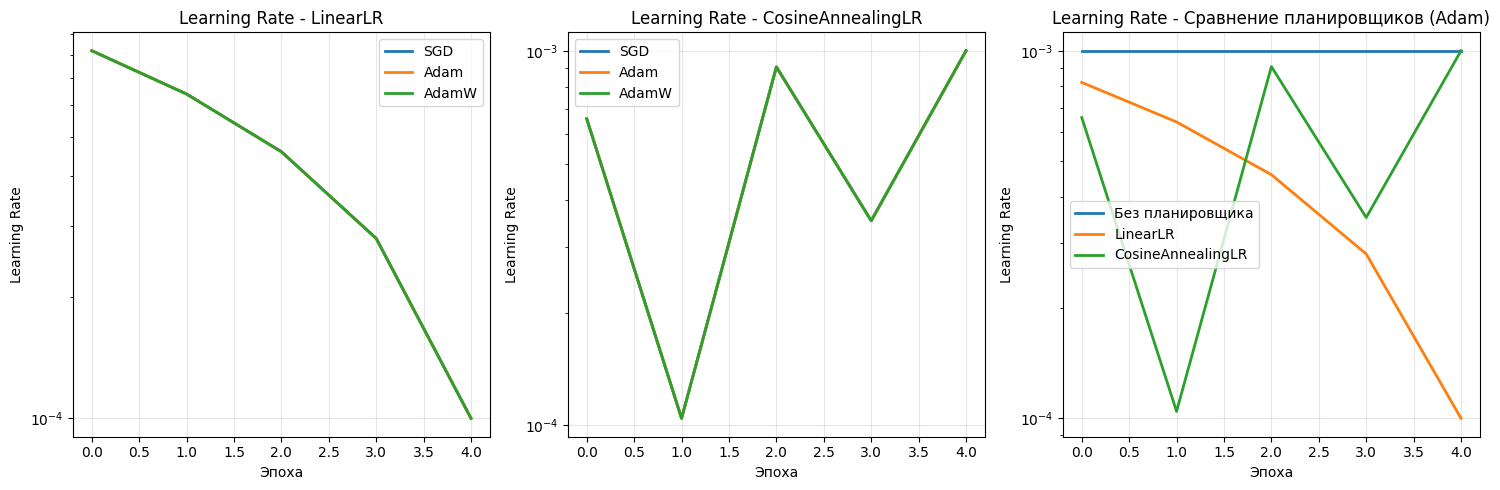

In [30]:
# Построение графиков изменения learning rate
plt.figure(figsize=(15, 5))

# График 1: Эксперименты с LinearLR
plt.subplot(1, 3, 1)
for exp_name, results in all_results.items():
    if 'LinearLR' in exp_name:
        optimizer_type = exp_name.split(' +')[0]
        lr_data = results['lr']
        plt.plot(lr_data, label=optimizer_type, linewidth=2)

plt.title('Learning Rate - LinearLR')
plt.xlabel('Эпоха')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# График 2: Эксперименты с CosineAnnealingLR
plt.subplot(1, 3, 2)
for exp_name, results in all_results.items():
    if 'CosineAnnealingLR' in exp_name:
        optimizer_type = exp_name.split(' +')[0]
        lr_data = results['lr']
        plt.plot(lr_data, label=optimizer_type, linewidth=2)

plt.title('Learning Rate - CosineAnnealingLR')
plt.xlabel('Эпоха')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# График 3: Сравнение всех планировщиков для Adam
plt.subplot(1, 3, 3)
adam_experiments = [name for name in all_results.keys() if 'Adam' in name and 'AdamW' not in name]
for exp_name in adam_experiments:
    lr_data = all_results[exp_name]['lr']
    label = exp_name.replace('Adam + ', '').replace('Adam', 'Без планировщика')
    plt.plot(lr_data, label=label, linewidth=2)

plt.title('Learning Rate - Сравнение планировщиков (Adam)')
plt.xlabel('Эпоха')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

просто так

In [32]:
# Тут уже попросим помощи и делаем пивот

summary_data = []
for exp_name, results in all_results.items():
    optimizer = exp_name.split(' +')[0].split()[0]
    scheduler = 'None'
    if 'LinearLR' in exp_name:
        scheduler = 'LinearLR'
    elif 'CosineAnnealingLR' in exp_name:
        scheduler = 'CosineAnnealingLR'

    summary_data.append({
        'Эксперимент': exp_name,
        'Оптимизатор': optimizer,
        'Планировщик': scheduler,
        'Финальная точность (тест)': f"{results['test_acc'][-1]:.2f}%",
        'Лучшая точность (тест)': f"{max(results['test_acc']):.2f}%",
        'Финальная потеря (тест)': f"{results['test_loss'][-1]:.4f}",
        'Минимальная потеря (тест)': f"{min(results['test_loss']):.4f}",
        'Финальный LR': f"{results['lr'][-1]:.2e}"
    })

df_summary = pd.DataFrame(summary_data)
print("=" * 180)
print("Результаты в пивот таблице")
print("=" * 180)
print(df_summary.to_string(index=False))
print("=" * 180)

Результаты в пивот таблице
              Эксперимент Оптимизатор       Планировщик Финальная точность (тест) Лучшая точность (тест) Финальная потеря (тест) Минимальная потеря (тест) Финальный LR
                      SGD         SGD              None                    95.12%                 95.12%                  0.1634                    0.1634     1.00e-03
                     Adam        Adam              None                    99.14%                 99.14%                  0.0292                    0.0292     1.00e-03
                    AdamW       AdamW              None                    99.13%                 99.13%                  0.0296                    0.0267     1.00e-03
           SGD + LinearLR         SGD          LinearLR                    91.41%                 91.41%                  0.2921                    0.2921     1.00e-04
          Adam + LinearLR        Adam          LinearLR                    99.44%                 99.44%                  0.0188     

## Выводы

1. **Сравнение оптимизаторов:**
   - **Adam vs AdamW**: AdamW ожидаемо лучше
   - **SGD**: Требует более тщательной настройки

2. **Влияние планировщиков learning rate:**
   - **LinearLR**: Помогает избежать переобучения в конце обучения
   - **CosineAnnealingLR**: Ожидамая кривая обучения. Может найти лучшие локальные минимумы

 **Планировщики помогают** найти лучшие минимумы и избежать переобучения
